In [38]:
# imports

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

np.random.seed(0)

In [39]:
# graph utilities

def nx_erdos_renyi_weighted(n, p=0.15, weight_scale=1.0, seed=0):
    rng = np.random.default_rng(seed)
    G = nx.erdos_renyi_graph(n=n, p=p, seed=seed, directed=False)

    for (u, v) in G.edges():
        w = weight_scale * (0.5 + rng.random())
        G[u][v]["weight"] = float(w)

    return G

def nx_laplacian(G, nodelist=None):
    """
    Returns weighted combinatorial Laplacian L as a dense numpy array.
    """
    if nodelist is None:
        nodelist = list(G.nodes())
    L = nx.laplacian_matrix(G, nodelist=nodelist, weight="weight").astype(float)
    return L.toarray(), nodelist

def nx_incidence(G, nodelist=None, oriented=True):
    """
    Returns incidence matrix B (N x M) as dense numpy array.
    NetworkX returns oriented incidence by default (arbitrary orientation).
    """
    if nodelist is None:
        nodelist = list(G.nodes())
    B = nx.incidence_matrix(G, nodelist=nodelist, oriented=oriented, weight=None).astype(float)
    edgelist = list(G.edges()) 
    return B.toarray(), edgelist, nodelist

def adjacency_dense(G, nodelist=None):
    if nodelist is None:
        nodelist = list(G.nodes())
    A = nx.to_numpy_array(G, nodelist=nodelist, weight="weight", dtype=float)
    return A, nodelist

In [40]:
# graph polynomial filter

def poly_graph_filter(L, h):
    """
    L: (N,N) dense numpy -> valid graph Laplacian
    h: (K+1,) coefficients
    """
    N = L.shape[0]
    out = h[0] * np.eye(N)
    Lk = np.eye(N)
    for k in range(1, len(h)):
        Lk = Lk @ L
        out += h[k] * Lk
    return out


In [41]:
# synthetic graph

G = nx_erdos_renyi_weighted(n=30, p=0.12, seed=1)
L, nodelist = nx_laplacian(G)
B, edgelist, _ = nx_incidence(G, nodelist=nodelist, oriented=True)
A, _ = adjacency_dense(G, nodelist=nodelist)

print("A shape:", A.shape, "L shape:", L.shape, "B shape:", B.shape)
print("num nodes:", G.number_of_nodes(), "num edges:", G.number_of_edges())
print("connected:", nx.is_connected(G))


A shape: (30, 30) L shape: (30, 30) B shape: (30, 59)
num nodes: 30 num edges: 59
connected: True


# Time series dynamic model 

The state space model as equation (12) follows:

Dynamics: $\bold{x}_{t+1} = (\bold{I}-c\bold{L})\bold{x}_t + \bold{B}\text{diag}(\bold{\alpha})\bold{w}_t$

Observations: $\bold{y}_t = \tilde{\bold{H}}(\bold{L})\bold{x}_t + \bold{v}_t$


In [42]:
# synthetic generator with baseline graph dynamics
def generate_synthetic_data(
    G,
    T=200,
    c=0.05,
    # observation model: y_t = M \tilde H(L) x_t + v_t
    K_obs=2,
    h_obs=None,
    sigma_obs=0.05,
    # dynamics uncertainty: B diag(alpha) w_t
    alpha=None,
    # init + missingness
    x0_std=0.5,
    obs_ratio=0.7,
    seed=0,
    nodelist=None,
):
    """
    Baseline state dynamics:
        x_{t+1} = (I - cL) x_t + B diag(alpha) w_t,   w_t ~ N(0, I)

    Observation model:
        y_t = \tilde H(L) x_t + v_t,                 v_t ~ N(0, sigma_obs^2 I)

    Missing observations are returned as NaNs.
    """
    rng = np.random.default_rng(seed)

    if nodelist is None:
        nodelist = list(G.nodes())

    # Graph operators
    L = nx.laplacian_matrix(G, nodelist=nodelist, weight="weight").astype(float).toarray()
    B = nx.incidence_matrix(G, nodelist=nodelist, oriented=True, weight=None).astype(float).toarray()

    N = L.shape[0]
    M = B.shape[1]

    # observation filter coefficients for \tilde H(L)
    if h_obs is None:
        h_obs = np.zeros(K_obs + 1, dtype=float)
        h_obs[0] = 1.0
        for k in range(1, K_obs + 1):
            h_obs[k] = (-1.0) * (0.1 ** k)

    Htilde = poly_graph_filter(L, h_obs)

    # edge uncertainty vector alpha (length = number of edges)
    if alpha is None:
        alpha = 0.1 * np.ones(M, dtype=float)
    alpha = np.asarray(alpha, dtype=float).reshape(-1)
    if alpha.shape[0] != M:
        raise ValueError(f"alpha must have length {M}, got {alpha.shape[0]}")

    # dynamics matrix
    F = np.eye(N) - c * L

    # Simulate
    X = np.zeros((T, N), dtype=float)
    Y_full = np.zeros((T, N), dtype=float)

    x = rng.normal(0.0, x0_std, size=N)
    for t in range(T):
        # observation
        v = rng.normal(0.0, sigma_obs, size=N)
        y = Htilde @ x + v

        X[t] = x
        Y_full[t] = y

        # state update
        w_t = rng.normal(0.0, 1.0, size=M)
        x = F @ x + B @ (alpha * w_t)

    # missing observations
    Mmask = rng.random((T, N)) < obs_ratio
    Y_obs = Y_full.copy()
    Y_obs[~Mmask] = np.nan

    meta = {
        "nodelist": nodelist,
        "L": L,
        "B": B,
        "F": F,
        "Htilde": Htilde,
        "h_obs": h_obs,
        "alpha": alpha,
        "c": c,
        "sigma_obs": sigma_obs,
        "obs_ratio": obs_ratio,
    }
    return X, Y_full, Y_obs, Mmask, meta


In [43]:
# sample synthetic data

X, Y_full, Y_obs, Mmask, meta = generate_synthetic_data(
    G, T=150, c=0.06, K_obs=2, sigma_obs=0.05, obs_ratio=0.75, seed=2
)

print("Shapes:", X.shape, Y_full.shape, Y_obs.shape)
print("Observed fraction:", Mmask.mean())


Shapes: (150, 30) (150, 30) (150, 30)
Observed fraction: 0.7455555555555555


# Kalman filtering and RTS smoothing

In [44]:
# Kalman filter with missing observations (mask-based)
def process_noise_cov(B, alpha):
    """
    Q = B diag(alpha^2) B^T  (since w_t ~ N(0, I))
    """
    alpha = np.asarray(alpha, dtype=float).reshape(-1)
    return B @ np.diag(alpha**2) @ B.T


def kalman_filter(Y_obs, Mmask, meta, x0=None, P0=None, jitter=1e-9):
    """
    Kalman filter for:
        x_{t+1} = F x_t + q_t,     q_t ~ N(0, Q)
        y_t     = Htilde x_t + v_t, v_t ~ N(0, R), with R = sigma_obs^2 I

    Inputs:
      Y_obs: (T, N) with np.nan for missing (can be ignored if Mmask provided)
      Mmask: (T, N) bool, True = observed
      meta: dict with F, Htilde, B, alpha, sigma_obs
      x0: (N,) initial mean (default zeros)
      P0: (N,N) initial cov  (default identity)
      jitter: small value to stabilize inverses (default 1e-9)

    Returns:
      out: dict containing sequences:
        x_pred, P_pred: prior (before update) for x_t
        x_filt, P_filt: posterior (after update) for x_t
        loglik: total log-likelihood of observed data under the filter
    """
    F = meta["F"]
    Htilde = meta["Htilde"]
    B = meta["B"]
    alpha = meta["alpha"]
    sigma_obs = float(meta["sigma_obs"])

    T, N = Y_obs.shape
    Q = process_noise_cov(B, alpha)
    # base observation noise variance (per node)
    R_full = (sigma_obs**2) * np.eye(N)

    if x0 is None:
        x0 = np.zeros(N, dtype=float)
    if P0 is None:
        P0 = 10.0 * np.eye(N, dtype=float)

    x_pred = np.zeros((T, N), dtype=float)
    x_filt = np.zeros((T, N), dtype=float)
    P_pred = np.zeros((T, N, N), dtype=float)
    P_filt = np.zeros((T, N, N), dtype=float)

    loglik = 0.0

    # initialize with prior for x_0
    x_prev = x0.copy()
    P_prev = P0.copy()

    I = np.eye(N, dtype=float)

    for t in range(T):
        # ---- Predict step for x_t from x_{t-1} ----
        if t > 0:
            x_prev = F @ x_prev
            P_prev = F @ P_prev @ F.T + Q

        x_pred[t] = x_prev
        P_pred[t] = P_prev

        # ---- Update step with observed entries at time t ----
        obs_idx = np.where(Mmask[t])[0]
        m = obs_idx.size

        if m == 0:
            # no measurement update
            x_filt[t] = x_prev
            P_filt[t] = P_prev
            continue

        y_t = Y_obs[t, obs_idx].astype(float)  # (m,)
        # observation matrix restricted to observed nodes:
        # y_obs = H_obs x + v_obs, where H_obs = (Htilde rows at obs_idx)
        H_obs = Htilde[obs_idx, :]             # (m, N)
        R_obs = R_full[np.ix_(obs_idx, obs_idx)]  # (m, m) diagonal

        # innovation
        y_hat = H_obs @ x_prev
        e = y_t - y_hat

        # innovation covariance
        S = H_obs @ P_prev @ H_obs.T + R_obs
        S = S + jitter * np.eye(m)

        # Kalman gain
        PHt = P_prev @ H_obs.T
        K = np.linalg.solve(S, PHt.T).T

        # mean update
        x_new = x_prev + K @ e

        # covariance update (Joseph form)
        KH = K @ H_obs
        P_new = (I - KH) @ P_prev @ (I - KH).T + K @ R_obs @ K.T


        x_filt[t] = x_new
        P_filt[t] = P_new

        # log-likelihood contribution: N(e; 0, S)
        sign, logdetS = np.linalg.slogdet(S)
        if sign <= 0:
            # fallback (should be rare with jitter)
            logdetS = np.log(np.maximum(np.linalg.det(S), 1e-300))
        ll_t = -0.5 * (m * np.log(2.0 * np.pi) + logdetS + e.T @ np.linalg.solve(S, e))
        loglik += float(ll_t)

        # carry forward
        x_prev, P_prev = x_new, P_new

    return {
        "x_pred": x_pred,
        "P_pred": P_pred,
        "x_filt": x_filt,
        "P_filt": P_filt,
        "Q": Q,
        "loglik": loglik,
    }


In [45]:
# run the filter on  synthetic data

kf_out = kalman_filter(Y_obs, Mmask, meta)

print("Filter done.")
print("Total log-likelihood:", kf_out["loglik"])
print("x_filt shape:", kf_out["x_filt"].shape)


Filter done.
Total log-likelihood: 2489.5598561762963
x_filt shape: (150, 30)


In [46]:
# RTS smoother (backward pass) 
def rts_smoother(kf_out, meta, compute_lag1=True, jitter=1e-12):
    """
    Rauch–Tung–Striebel smoother for:
        x_{t+1} = F x_t + q_t,  q_t ~ N(0, Q)

    Inputs:
      kf_out: dict from kalman_filter() containing x_pred,P_pred,x_filt,P_filt,Q
      meta:   dict containing F
      compute_lag1: if True, compute P_{t,t-1}^s (useful for EM)
      jitter: stabilizer for inverses

    Returns:
      out: dict with:
        x_smooth: (T,N)
        P_smooth: (T,N,N)
        (optional) P_lag1: (T,N,N) where P_lag1[t] = Cov(x_t, x_{t-1} | y_{0:T-1})
                          and P_lag1[0] is zeros
        J: smoothing gains (T-1,N,N)
    """
    F = meta["F"]
    x_pred = kf_out["x_pred"]
    P_pred = kf_out["P_pred"]
    x_filt = kf_out["x_filt"]
    P_filt = kf_out["P_filt"]

    T, N = x_filt.shape
    I = np.eye(N)

    x_smooth = np.zeros_like(x_filt)
    P_smooth = np.zeros_like(P_filt)
    J = np.zeros((T-1, N, N), dtype=float)

    if compute_lag1:
        P_lag1 = np.zeros((T, N, N), dtype=float)
    else:
        P_lag1 = None

    # init at final time
    x_smooth[-1] = x_filt[-1]
    P_smooth[-1] = P_filt[-1]

    # backward recursion
    for t in range(T-2, -1, -1):
        # initialize by Kalman filter predictions
        Pp = P_pred[t+1]
        # stabilizer (if near-singular)
        Pp = Pp + jitter * I

        # smoothing gain: J_t = P_filt[t] F^T (P_pred[t+1])^{-1}
        # Solve Pp^T X^T = (P_filt[t] F^T)^T  -> X = J_t
        A = P_filt[t] @ F.T
        J_t = np.linalg.solve(Pp, A.T).T
        J[t] = J_t

        # smoothed mean
        x_smooth[t] = x_filt[t] + J_t @ (x_smooth[t+1] - x_pred[t+1])

        # smoothed covariance
        P_smooth[t] = P_filt[t] + J_t @ (P_smooth[t+1] - P_pred[t+1]) @ J_t.T

        if compute_lag1:
            # lag-one covariance: P_{t+1,t}^s = P_smooth[t+1] J_t^T
            # store as Cov(x_{t+1}, x_t | Y)
            P_lag1[t+1] = P_smooth[t+1] @ J_t.T

    out = {
        "x_smooth": x_smooth,
        "P_smooth": P_smooth,
        "J": J,
    }
    if compute_lag1:
        out["P_lag1"] = P_lag1
    return out


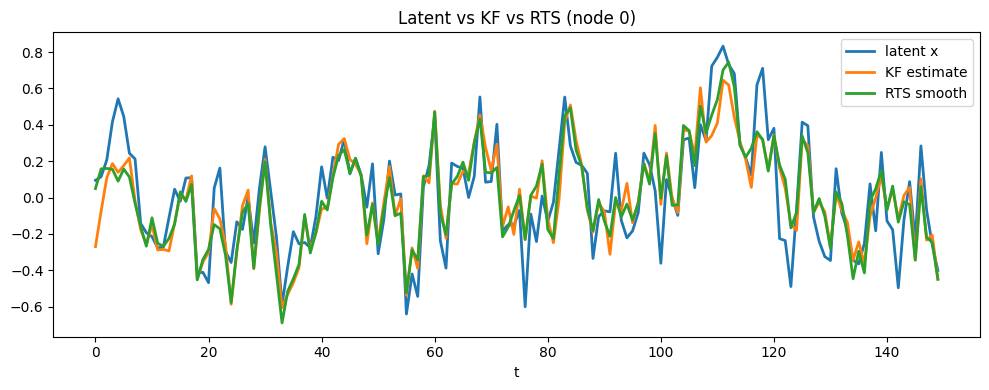

x_smooth shape: (150, 30)
P_lag1 shape: (150, 30, 30)


In [47]:
# Run RTS smoother and plot one node vs latent
sm_out = rts_smoother(kf_out, meta, compute_lag1=True)

node = 0
t = np.arange(X.shape[0])

plt.figure(figsize=(10, 4))
plt.plot(t, X[:, node], linewidth=2, label="latent x")
plt.plot(t, kf_out["x_filt"][:, node], linewidth=2, label="KF estimate")
plt.plot(t, sm_out["x_smooth"][:, node], linewidth=2, label="RTS smooth")
plt.title(f"Latent vs KF vs RTS (node {node})")
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()

print("x_smooth shape:", sm_out["x_smooth"].shape)
if "P_lag1" in sm_out:
    print("P_lag1 shape:", sm_out["P_lag1"].shape)


# EM-based estimation of model parameters

In [48]:
def update_meta_matrices(meta):
    """
    Keeps compatibility with existing KF/RTS code that expects:
      meta["F"], meta["Htilde"]

    Requires:
      meta["L"], meta["c"], meta["h_obs"]
    """
    L = meta["L"]
    c = float(meta["c"])
    h = np.asarray(meta["h_obs"], dtype=float).reshape(-1)

    N = L.shape[0]
    meta["F"] = np.eye(N) - c * L
    meta["Htilde"] = poly_graph_filter(L, h)  # uses YOUR existing poly_graph_filter
    return meta


In [49]:
# M-step loss for EM parameter estimation

def softplus(x):
    return jnp.log1p(jnp.exp(-jnp.abs(x))) + jnp.maximum(x, 0)

def inv_softplus(y):
    y = np.maximum(np.asarray(y), 1e-8)
    return np.log(np.expm1(y))

@jax.jit
def poly_graph_filter_jax(L, h):
    # H = Σ_k h[k] L^k
    N = L.shape[0]
    out = h[0] * jnp.eye(N, dtype=L.dtype)
    Lk = jnp.eye(N, dtype=L.dtype)
    for k in range(1, h.shape[0]):
        Lk = Lk @ L
        out = out + h[k] * Lk
    return out

@jax.jit
def em_loss(theta_alpha, theta_sigma, theta_c, theta_h,
            L, B,
            x_s, P_s, P_lag1,
            y_filled, mask,
            jitter_Q=1e-6, min_sigma=1e-8, reg_h=0.0):
    """
    Generalized EM M-step loss (negative expected complete-data loglik up to constants).

    Parameters (unconstrained):
      theta_alpha -> alpha = softplus(theta_alpha) >= 0
      theta_sigma -> sigma = softplus(theta_sigma) + min_sigma > 0
      theta_c     -> c     = softplus(theta_c) > 0
      theta_h     -> h     (free; can be any real vector)

    Inputs from E-step:
      x_s: (T,N), P_s: (T,N,N), P_lag1: (T,N,N) with Cov(x_t, x_{t-1})

    Observations:
      y_filled: (T,N) with missing entries filled with 0
      mask:     (T,N) float in {0,1}
    """
    alpha = softplus(theta_alpha) + 1e-3
    sigma = softplus(theta_sigma) + min_sigma
    c_raw = softplus(theta_c)
    c = jnp.clip(c_raw, 1e-6, 0.2)
    h = theta_h

    N = L.shape[0]
    F = jnp.eye(N, dtype=L.dtype) - c * L
    H = poly_graph_filter_jax(L, h)

    # Q(alpha) = B diag(alpha^2) B^T
    Q = B @ ((alpha**2)[:, None] * B.T)
    Qj = Q + jitter_Q * jnp.eye(N, dtype=L.dtype)
    sign, logdetQ = jnp.linalg.slogdet(Qj)
    Qinv = jnp.linalg.inv(Qj)

    T = x_s.shape[0]

    # ----- process term -----
    def proc_step(t, acc):
        Ex1x1 = P_s[t+1] + jnp.outer(x_s[t+1], x_s[t+1])
        Extxt = P_s[t]   + jnp.outer(x_s[t],   x_s[t])
        Ex1xt = P_lag1[t+1] + jnp.outer(x_s[t+1], x_s[t])   # E[x_{t+1} x_t^T]
        Extx1 = Ex1xt.T
        Sqt = Ex1x1 - F @ Extx1 - Ex1xt @ F.T + F @ Extxt @ F.T
        return acc + Sqt

    Sq = jax.lax.fori_loop(0, T-1, proc_step, jnp.zeros((N, N), dtype=L.dtype))
    n_steps = T - 1
    proc = 0.5 * (n_steps * logdetQ + jnp.trace(Qinv @ Sq))

    # ----- observation term (masked, sigma^2 I) -----
    def obs_step(t, acc):
        mean_pred = H @ x_s[t]                        # (N,)
        resid = (y_filled[t] - mean_pred) * mask[t]   # (N,)
        sse_mean = jnp.sum(resid**2)

        HP = H @ P_s[t]
        var_diag = jnp.sum(HP * H, axis=1)            # diag(H P H^T)
        sse_var = jnp.sum(var_diag * mask[t])

        return acc + (sse_mean + sse_var)

    sse = jax.lax.fori_loop(0, T, obs_step, jnp.array(0.0, dtype=L.dtype))
    nobs = jnp.sum(mask)
    obs = 0.5 * (nobs * jnp.log(sigma**2) + sse / (sigma**2))

    # optional regularization on h to stabilize
    reg = reg_h * jnp.sum(h**2)

    return proc + obs + reg


In [50]:
loss_and_grads = jax.jit(jax.value_and_grad(em_loss, argnums=(0,1,2,3)))

def clip(g, max_norm=1.0):
    n = jnp.linalg.norm(g)
    return jnp.where(n > max_norm, g * (max_norm / (n + 1e-12)), g)

def em_train_jax(
    Y_obs, Mmask, meta,
    n_iter=6,
    m_steps=40,
    lr_alpha=1e-2,
    lr_sigma=2e-2,
    lr_c=2e-2,
    lr_h=2e-3,
    jitter_Q=1e-6,
    reg_h=0.0,
    verbose=True
):
    """
    Keeps your existing notation:
      - E-step uses meta["F"], meta["Htilde"], meta["alpha"], meta["sigma_obs"], meta["B"]
      - We also require meta["L"], meta["c"], meta["h_obs"] so we can learn c,h and update F,Htilde.

    Returns: history, updated_meta
    """
    meta_out = dict(meta)

    # JAX constants
    L_j = jnp.array(meta_out["L"], dtype=jnp.float64)
    B_j = jnp.array(meta_out["B"], dtype=jnp.float64)

    y_filled = np.nan_to_num(Y_obs, nan=0.0).astype(np.float32)
    mask_f = Mmask.astype(np.float32)
    y_j = jnp.array(y_filled, dtype=jnp.float64)
    m_j = jnp.array(mask_f, dtype=jnp.float64)  

    # init unconstrained params from meta
    theta_alpha = jnp.array(inv_softplus(np.asarray(meta_out["alpha"], float)), dtype=jnp.float32)
    theta_sigma = jnp.array(inv_softplus(np.array(float(meta_out["sigma_obs"]))), dtype=jnp.float32)
    theta_c     = jnp.array(inv_softplus(np.array(float(meta_out["c"]))), dtype=jnp.float32)
    theta_h     = jnp.array(np.asarray(meta_out["h_obs"], float), dtype=jnp.float32)  # unconstrained

    history = []

    for it in range(n_iter):
        # write params -> meta (so your KF/RTS uses them)
        meta_out["alpha"] = np.array(softplus(theta_alpha), dtype=float)
        meta_out["sigma_obs"] = float(np.array(softplus(theta_sigma)))
        meta_out["c"] = float(np.array(softplus(theta_c)))
        meta_out["h_obs"] = np.array(theta_h, dtype=float)

        update_meta_matrices(meta_out)  # sets meta["F"] and meta["Htilde"] (compatible)

        # ---- E-step (your code) ----
        kf_out = kalman_filter(Y_obs, Mmask, meta_out)
        sm_out = rts_smoother(kf_out, meta_out, compute_lag1=True)

        x_s = jnp.array(sm_out["x_smooth"], dtype=jnp.float64)
        P_s = jnp.array(sm_out["P_smooth"], dtype=jnp.float64)
        P_l = jnp.array(sm_out["P_lag1"], dtype=jnp.float64)

        # ---- M-step (JAX gradients) ----
        for _ in range(m_steps):
            loss_val, (g_a, g_s, g_c, g_h) = loss_and_grads(
                theta_alpha, theta_sigma, theta_c, theta_h,
                L_j, B_j, x_s, P_s, P_l, y_j, m_j,
                jitter_Q=jitter_Q, reg_h=reg_h
            )

            theta_alpha = theta_alpha - lr_alpha * clip(g_a, 5.0)
            theta_sigma = theta_sigma - lr_sigma * clip(g_s, 5.0)
            theta_c     = theta_c     - lr_c     * clip(g_c, 5.0)
            theta_h     = theta_h     - lr_h     * clip(g_h, 5.0)

        rec = {
            "iter": it,
            "loglik": float(kf_out["loglik"]),
            "loss": float(np.array(loss_val)),
            "sigma_obs": float(np.array(softplus(theta_sigma))),
            "c": float(np.array(softplus(theta_c))),
            "alpha_mean": float(np.array(softplus(theta_alpha)).mean()),
            "h_norm": float(np.linalg.norm(np.array(theta_h))),
        }
        history.append(rec)

        if verbose:
            print(f"[EM] iter={it:02d} loglik={rec['loglik']:.3f} loss={rec['loss']:.3e} "
                  f"sigma={rec['sigma_obs']:.4g} c={rec['c']:.4g} "
                  f"alpha_mean={rec['alpha_mean']:.4g} |h|={rec['h_norm']:.4g}")

    # final writeback
    meta_out["alpha"] = np.array(softplus(theta_alpha), dtype=float)
    meta_out["sigma_obs"] = float(np.array(softplus(theta_sigma)))
    meta_out["c"] = float(np.array(softplus(theta_c)))
    meta_out["h_obs"] = np.array(theta_h, dtype=float)
    update_meta_matrices(meta_out)

    return history, meta_out


In [51]:
# Make sure meta has L, c, h_obs, plus the KF-required keys.
# If meta currently already has F and Htilde from your generator, that's fine; update_meta_matrices will overwrite them.

hist, meta_learned = em_train_jax(
    Y_obs, Mmask, meta,
    n_iter=10,
    m_steps=40,
    lr_alpha=1e-2,
    lr_sigma=2e-2,
    lr_c=2e-2,
    lr_h=2e-3,
    reg_h=1e-6,   # small stabilizer; you can set 0.0
    verbose=True
)


[EM] iter=00 loglik=2489.560 loss=-2.463e+03 sigma=0.05 c=0.06 alpha_mean=0.09871 |h|=1.004
[EM] iter=01 loglik=2503.596 loss=-2.538e+03 sigma=0.05 c=0.06 alpha_mean=0.09764 |h|=1.003
[EM] iter=02 loglik=2510.512 loss=-2.605e+03 sigma=0.05 c=0.06 alpha_mean=0.09678 |h|=1.002
[EM] iter=03 loglik=2514.094 loss=-2.670e+03 sigma=0.05 c=0.06 alpha_mean=0.09604 |h|=1.002
[EM] iter=04 loglik=2516.022 loss=-2.735e+03 sigma=0.05 c=0.06 alpha_mean=0.0954 |h|=1.002
[EM] iter=05 loglik=2517.066 loss=-2.803e+03 sigma=0.05 c=0.06 alpha_mean=0.09484 |h|=1.001
[EM] iter=06 loglik=2517.666 loss=-3.210e+03 sigma=0.05069 c=0.06 alpha_mean=0.09434 |h|=1.001
[EM] iter=07 loglik=2517.842 loss=-3.249e+03 sigma=0.05069 c=0.06 alpha_mean=0.09374 |h|=1.001
[EM] iter=08 loglik=2517.955 loss=-3.321e+03 sigma=0.05069 c=0.06 alpha_mean=0.09324 |h|=1
[EM] iter=09 loglik=2517.979 loss=-3.393e+03 sigma=0.05069 c=0.06 alpha_mean=0.09281 |h|=1


In [52]:
# --- Numerical sanity checks ---
def check_finite(name, arr):
    if not np.all(np.isfinite(arr)):
        raise ValueError(f"{name} contains NaN or Inf")
    print(f"[OK] {name} finite")

check_finite("alpha", meta_learned["alpha"])
check_finite("sigma_obs", np.array(meta_learned["sigma_obs"]))
check_finite("c", np.array(meta_learned["c"]))
check_finite("h_obs", meta_learned["h_obs"])

# Q should be symmetric positive definite
Q = process_noise_cov(meta_learned["B"], meta_learned["alpha"])
eig_Q = np.linalg.eigvalsh(Q)
print("Q min eig:", eig_Q.min())
assert eig_Q.min() > 0, "Q is not positive definite"

# F stability: spectral radius < 1 (discrete-time stability)
F = meta_learned["F"]
rho_F = max(abs(np.linalg.eigvals(F)))
print("spectral radius(F):", rho_F)


[OK] alpha finite
[OK] sigma_obs finite
[OK] c finite
[OK] h_obs finite
Q min eig: 1.8546066352427962e-17
spectral radius(F): 0.9999999999999999


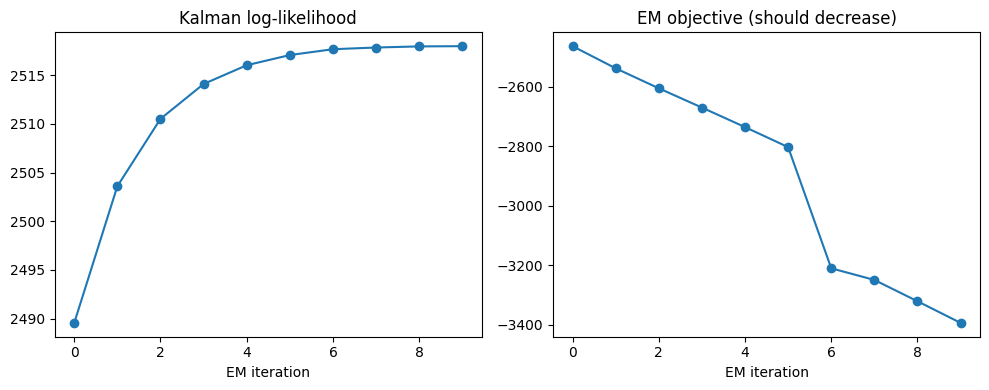

In [53]:
# --- EM diagnostics ---
loglik = [h["loglik"] for h in hist]
loss = [h["loss"] for h in hist]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loglik, marker="o")
plt.title("Kalman log-likelihood")
plt.xlabel("EM iteration")

plt.subplot(1,2,2)
plt.plot(loss, marker="o")
plt.title("EM objective (should decrease)")
plt.xlabel("EM iteration")
plt.tight_layout()
plt.show()


In [54]:
# --- Observation residual sanity ---
kf_learned = kalman_filter(Y_obs, Mmask, meta_learned)
sm_learned = rts_smoother(kf_learned, meta_learned, compute_lag1=False)

H = meta_learned["Htilde"]
x_hat = sm_learned["x_smooth"]

residuals = []
for t in range(Y_obs.shape[0]):
    idx = np.where(Mmask[t])[0]
    if idx.size == 0:
        continue
    y = Y_obs[t, idx]
    y_hat = (H @ x_hat[t])[idx]
    residuals.append(np.mean((y - y_hat)**2))

print("Mean obs MSE:", np.mean(residuals))
print("Std obs MSE:", np.std(residuals))


Mean obs MSE: 0.0008420113941089878
Std obs MSE: 0.00029757804031010926


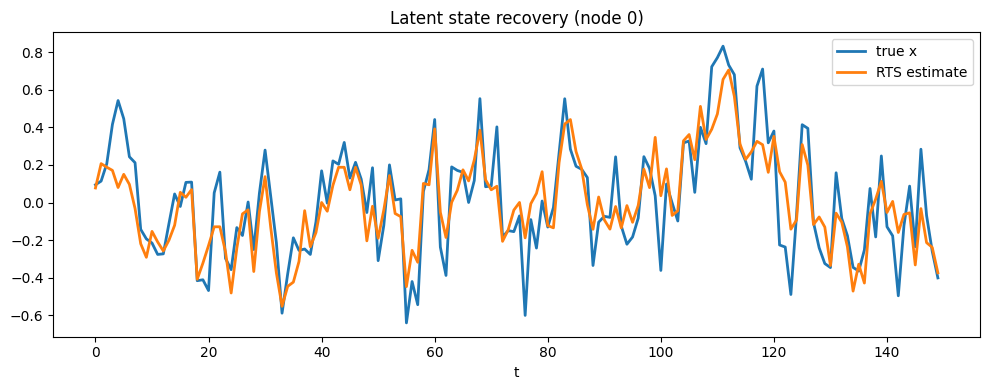

In [55]:
# --- Latent state recovery ---
node = 0
t = np.arange(X.shape[0])

plt.figure(figsize=(10,4))
plt.plot(t, X[:, node], label="true x", linewidth=2)
plt.plot(t, sm_learned["x_smooth"][:, node], label="RTS estimate", linewidth=2)
plt.title(f"Latent state recovery (node {node})")
plt.xlabel("t")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
print("True c:", meta["c"], " | Learned c:", meta_learned["c"])
print("True sigma:", meta["sigma_obs"], " | Learned sigma:", meta_learned["sigma_obs"])

print("True alpha mean:", meta["alpha"].mean())
print("Learned alpha mean:", meta_learned["alpha"].mean())

print("True h:", meta["h_obs"])
print("Learned h:", meta_learned["h_obs"])


True c: 0.06  | Learned c: 0.059999994933605194
True sigma: 0.05  | Learned sigma: 0.05069277435541153
True alpha mean: 0.09999999999999998
Learned alpha mean: 0.09281083202715647
True h: [ 1.   -0.1  -0.01]
Learned h: [ 0.99583447 -0.09383912 -0.01087316]
